# Hyperparameter Tuning

####  Group09 - Zeju Li - 836871789
####  Group09- Zonghong Yu - 803616657
#### Group09 - Zezhen Liu - 815679653

### **This just the steps for us to improve our models through hyperparameter tuning. For major depolyment app, please check app.py file.(We mainly use streamlit, which is much easier for us to test and deploy)** 

In [9]:
import random
from seaborn.palettes import color_palette
random.seed(1789) # use last four digits of GUID
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [10]:
#get data set
file_path = '../datasets/bank-additional-full.csv'
# the original dataset is seperated by ';'
bank_df = pd.read_csv(file_path,sep=";")

##### Below is some preprocessed step we have done in project 2 before performing GridSerach CV and Random Serach CV

In [11]:
bank_df = bank_df.drop('duration', axis=1)
bank_df['y'] = bank_df['y'].map({'no': 0, 'yes': 1})
columns_to_encode = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

#  dummy for on hot enchhnoding
bank_df_encoded = pd.get_dummies(bank_df, columns=columns_to_encode)
columns_to_drop = [col for col in bank_df_encoded.columns if "_unknown" in col]
bank_df_encoded = bank_df_encoded.drop(columns=columns_to_drop)
bank_df = bank_df_encoded.copy()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# set up X and y
X = bank_df.drop('y', axis=1)
y = bank_df['y']

# split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1789)

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# do feature selection on the scaled training set (Do it on the training set to prevent data leakage)
# reduce features to half of the all features (top 25) to decrease the dimensionality
selector = SelectKBest(score_func=f_classif, k=25)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)

# do the same transformation on the scaled test data
X_test_selected = selector.transform(X_test_scaled)

# remember the names of the selected features
selected_mask = selector.get_support()
selected_columns = X.columns[selected_mask]
print("Selected Features:", selected_columns)


Selected Features: Index(['campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_blue-collar',
       'job_retired', 'job_student', 'marital_single', 'education_basic.9y',
       'education_university.degree', 'default_no', 'contact_cellular',
       'contact_telephone', 'month_apr', 'month_dec', 'month_mar', 'month_may',
       'month_oct', 'month_sep', 'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


### Classification Routine (For base and meta models we choose in project 2)


In [2]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
random.seed(1789)  # use last four digits of GUID

In [ ]:

'''
set up class object with functions defined
Below are the class functions that will be utilized to train models and obtain the corresponding scores such as accuracy, reall, and precision.
Which are important evaluations for model performance

'''

class ClassificationModels:
    # set up the new parameter 'model_name' so that we can deal with each model independently this time
    def __init__(self, X_train, y_train, model_name):
        self.X_train = X_train
        self.y_train = y_train
        self.model_name = model_name

        # dictionary to map model names to their classifier
        # this time we only need for RandomForestClassifier(), BaggingClassifier(), and XGboostclassifier()
        model_dict = {
            "Random Forest": RandomForestClassifier(random_state=1789),
            "Bagging": BaggingClassifier(random_state=1789),
            "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=1789),
            "Gradient Boosting": GradientBoostingClassifier(random_state=1789)
        }

        # fetch the model from the dictionary then raise an error if not found
        self.model = model_dict.get(model_name)
        if self.model is None:
            raise ValueError(f"Unsupported model_name: {model_name}")
        #set up data frame for storage
        self.scores = pd.DataFrame(
            {'accuracy': [], 'recall': [], 'precision': []})

    # train the models with cross validation
    def train_model(self):
        # apply cross_val_score to compute the metrics individually
        self.accuracy_scores = cross_val_score(
            self.model, self.X_train, self.y_train, cv=5, scoring='accuracy')
        self.recall_scores = cross_val_score(
            self.model, self.X_train, self.y_train, cv=5, scoring='recall')
        self.precision_scores = cross_val_score(
            self.model, self.X_train, self.y_train, cv=5, scoring='precision')

        # store result into  self.scores
        self.scores = pd.DataFrame({
            'accuracy': self.accuracy_scores,
            'recall': self.recall_scores,
            'precision': self.precision_scores
        })

    # this function calculate and return the mean scores for accuracy, recall, and precision in a DataFrame

    def get_mean_scores(self):
        mean_scores = pd.DataFrame({
            'accuracy': [np.mean(self.accuracy_scores)],
            'recall': [np.mean(self.recall_scores)],
            'precision': [np.mean(self.precision_scores)]
        })
        return mean_scores

    def visualize_scores(self):
        sns.set_palette("pastel")

        # select the style of the visualization
        sns.set_style("whitegrid")

        # set up  figure size
        plt.figure(figsize=(10, 7))

        # plot a boxplot for accuracy
        sns.boxplot(y=self.scores['accuracy'],
                    width=0.5, fliersize=5, linewidth=1.5)

        #  title and labels
        plt.title(
            f'{self.model_name} Accuracy using Cross-Validation', fontsize=18)
        plt.ylabel('Accuracy', fontsize=15)
        plt.xticks([0], ['Accuracy'], fontsize=12)
        plt.yticks(fontsize=12)

        # show the plot
        plt.show()

    # get default models paramters
    def get_model_params(self):
        return self.model.get_params()


##### The base and meta models we choose before are **Random Forest**, **Gradient Boosting**, **Bagging**, and **XGBoost**, where **XGBoost** is meta model.

## Perform the Default setting first

##### RandomForestClassifier():

Random Forest Mean Scores:
   accuracy    recall  precision
0   0.89041  0.317891   0.522396

Random Forest Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1789, 'verbose': 0, 'warm_start': False}


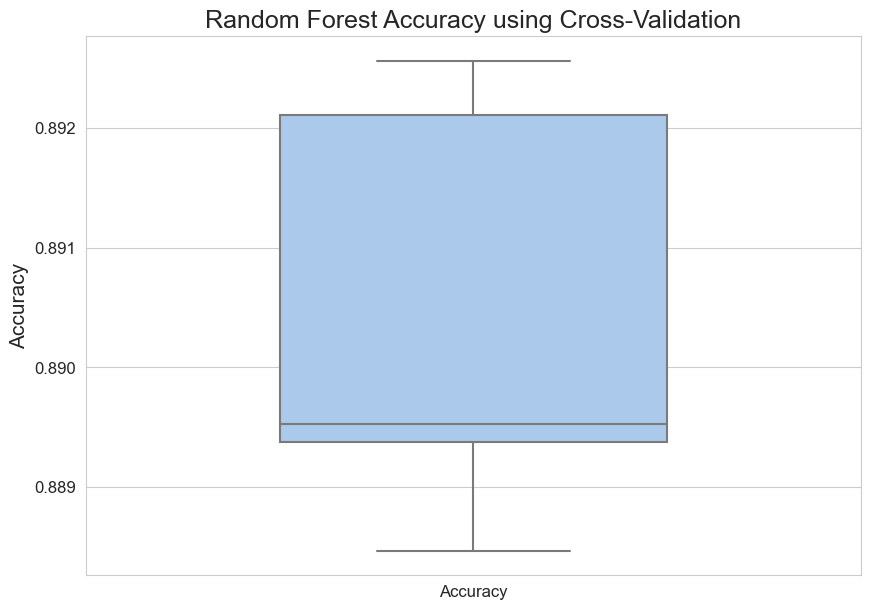

In [ ]:
if __name__ == '__main__':
    # use randomForest Model
    rf_model = ClassificationModels(X_train_selected, y_train, 'Random Forest')
    rf_model.train_model()

    print("Random Forest Mean Scores:")
    print(rf_model.get_mean_scores())

    # show the default parameters of the Random Forest model
    print("\nRandom Forest Parameters:")
    print(rf_model.get_model_params())

    rf_model.visualize_scores()

#### BaggingClassifier():


Bagging Mean Scores:
   accuracy    recall  precision
0  0.886677  0.307654   0.495552

Bagging Model Parameters:
{'base_estimator': 'deprecated', 'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 1789, 'verbose': 0, 'warm_start': False}


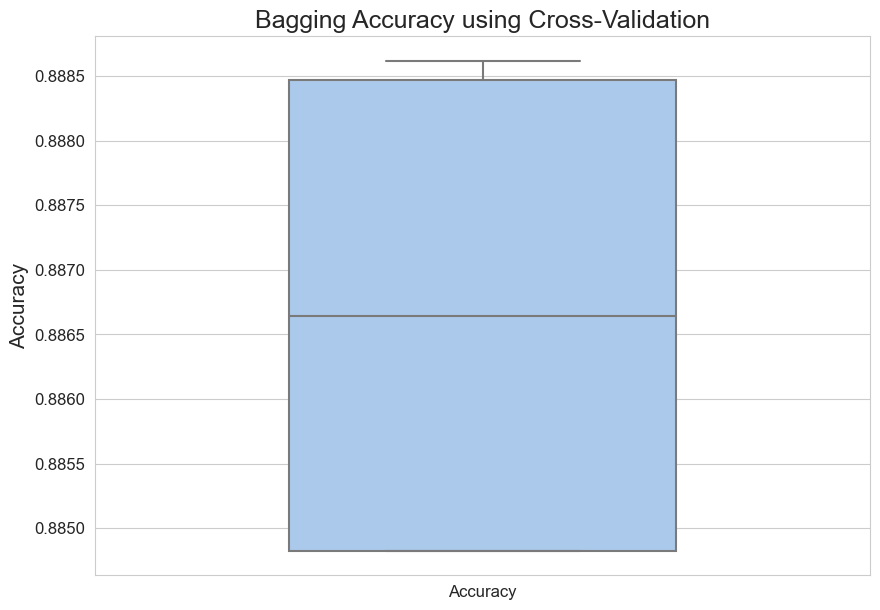

In [ ]:
if __name__ == '__main__':
    # this is bagging Model
    bagging_model = ClassificationModels(X_train_selected, y_train, 'Bagging')
    bagging_model.train_model()

    print("\nBagging Mean Scores:")
    print(bagging_model.get_mean_scores())

    # show the default parameters of the Bagging model
    print("\nBagging Model Parameters:")
    print(bagging_model.get_model_params())

    bagging_model.visualize_scores()

#### GradientBoostingClassifier()


Gradient Boosting Mean Scores:
   accuracy    recall  precision
0  0.901851  0.251897   0.671985

Gradient Boosting Model Parameters:
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1789, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


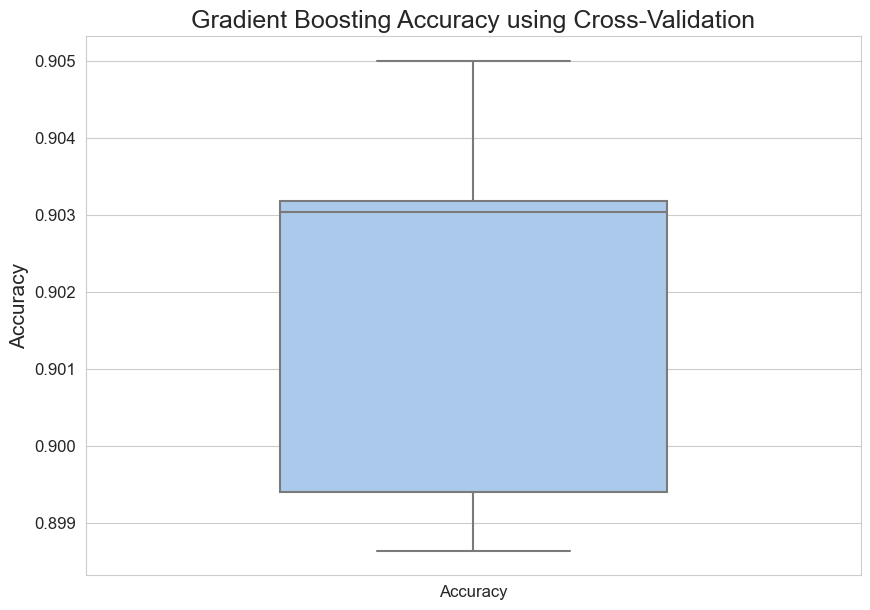

In [ ]:
if __name__ == '__main__':
    # this is gradient boosting Model
    gradientboost_model = ClassificationModels(X_train_selected, y_train, 'Gradient Boosting')
    gradientboost_model.train_model()

    print("\nGradient Boosting Mean Scores:")
    print(gradientboost_model.get_mean_scores())

    # show the default parameters of the gradient boosting model
    print("\nGradient Boosting Model Parameters:")
    print(gradientboost_model.get_model_params())

    gradientboost_model.visualize_scores()

#### XGboostclassifier():


XGBoost Mean Scores:
   accuracy    recall  precision
0  0.899181  0.282332   0.614323

XGBoost Model Parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 1789, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None,

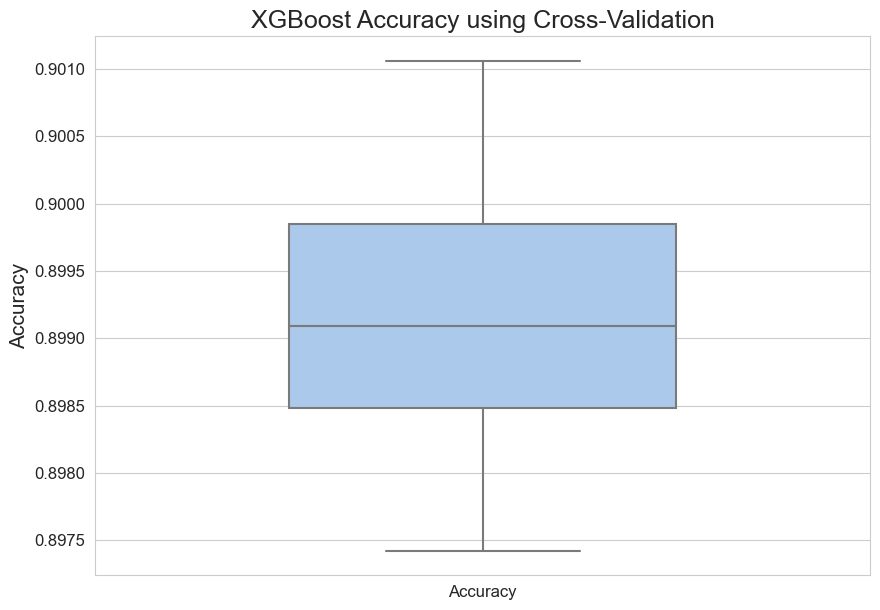

In [ ]:
if __name__ == '__main__':
    # XGBoost Model
    xgb_model = ClassificationModels(X_train_selected, y_train, 'XGBoost')
    xgb_model.train_model()

    print("\nXGBoost Mean Scores:")
    print(xgb_model.get_mean_scores())

    # Print the default parameters of the XGBoost model
    print("\nXGBoost Model Parameters:")
    print(xgb_model.get_model_params())

    xgb_model.visualize_scores()

## Now for GridSearchCV

In [ ]:
'''
The following class functions aim to evaluate the best model with grid search and hyperparameter tuning.
For the model, the functions will train the model and then return the corresponding accuracy and box plot for us to gain insights.
'''
class GridSearchRoutine:
    # get parameters
    def __init__(self, X_train, y_train, model_name):
        self.X_train = X_train
        self.y_train = y_train
        self.model_name = model_name

        self.models = {
            'RandomForest': RandomForestClassifier(random_state=1789),
            'Gradient Boosting': GradientBoostingClassifier(random_state=1789),
            'Bagging': BaggingClassifier(random_state=1789),
            'XGBoost': xgb.XGBClassifier(random_state=1789,eval_metric='logloss')
        }
        #make self.param_grids to function
        self.param_grids = {
            'RandomForest': {
                'n_estimators': [50, 100, 150, 200],
                'max_features': ['sqrt', 'log2'],
                'class_weight': [None, 'balanced'],
                'max_depth': [2, 4, 6, 8, 10, 12],
                'min_samples_split': [2, 3],
                'min_samples_leaf': [1, 2],
            },
            'Gradient Boosting': {
                'n_estimators': [50, 100, 150, 200],
                'learning_rate': [0.01, 0.1,0.2],
                'max_depth': [2,4,6,8,10],
                'min_samples_leaf': [1,2],
                'min_samples_split': [2,3]

            },
            'Bagging': {
                'n_estimators': [150,200,250,300],
                'max_samples': [0.1, 0.5, 0.7,1.0],
                'max_features': [0.1, 0.5, 0.7,1.0]
            },
            'XGBoost': {
                'n_estimators': [None,50, 100, 150, 200],
                'learning_rate': [0.001, 0.01, 0.1, 0.3],
                'max_depth': [2, 4, 6, 8,10],
                'min_child_weight': [1, 2, 3]
            }
        }
        self.best_params = {}
        self.best_scores = {}
        self.cv_results = {}
    #make a grid search
    def perform_grid_search(self):
        if self.model_name not in self.models:
            raise ValueError(f"Unsupported model_name: {self.model_name}")
        # use GridSearchCV
        gs = GridSearchCV(self.models[self.model_name], self.param_grids[self.model_name],
                          cv=5, scoring='accuracy', return_train_score=True)
        #fit
        gs.fit(self.X_train, self.y_train)
        self.best_params[self.model_name] = gs.best_params_
        self.best_scores[self.model_name] = gs.best_score_
        self.cv_results[self.model_name] = gs.cv_results_['mean_test_score']
        return self.best_params, self.best_scores, self.cv_results

    def visualize_scores(self):
        # set color palette
        sns.set_palette("pastel")

        # set the style for our plot
        sns.set_style("whitegrid")

        # set up  figure size
        plt.figure(figsize=(10, 7))

        # plot a boxplot for accuracy scores from cross-validation
        sns.boxplot(y=self.cv_results[self.model_name],
                    width=0.5, fliersize=5, linewidth=1.5)

        #  title and labels
        plt.title(
            f'{self.model_name} Accuracy using Cross-Validation', fontsize=18)
        plt.ylabel('Accuracy', fontsize=15)
        plt.xticks([0], ['Accuracy'], fontsize=12)
        plt.yticks(fontsize=12)

        # show the plot
        plt.show()


#### RandomForestClassifier():


RandomForest Results:
Best Parameters: {'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy Score: 0.9025189681335355


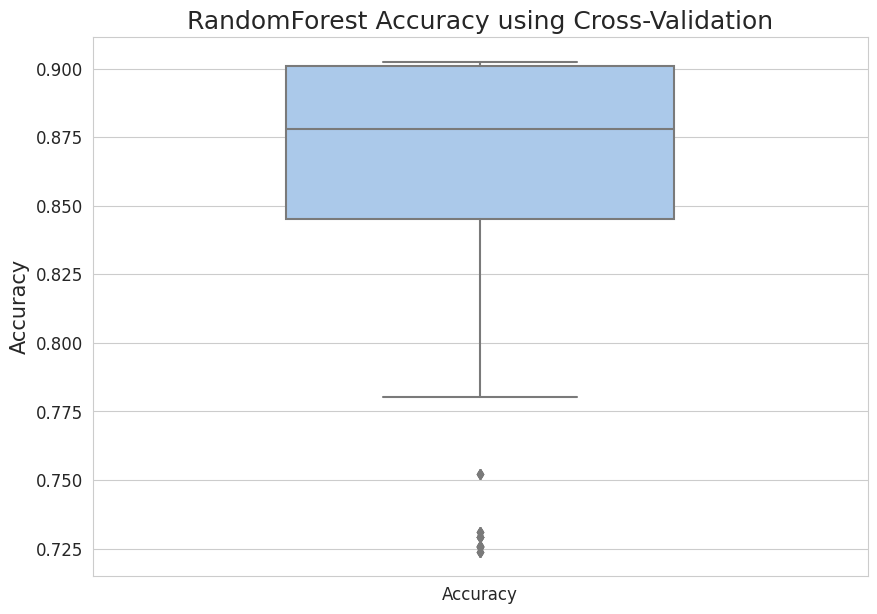

In [ ]:
if __name__ == '__main__':
    # the randomForest Model
    rf_grid_search = GridSearchRoutine(X_train_selected, y_train, 'RandomForest')
    rf_best_params, rf_best_scores, rf_cv_results = rf_grid_search.perform_grid_search()
    print("\nRandom Forest Results:")
    print(f"Best Parameters: {rf_best_params['RandomForest']}")
    print(f"Best Accuracy Score: {rf_best_scores['RandomForest']}")
    rf_grid_search.visualize_scores()

#### BaggingClassifier():


Bagging Results:
Best Parameters: {'max_features': 0.5, 'max_samples': 0.1, 'n_estimators': 200}
Best Accuracy Score: 0.9018512898330805


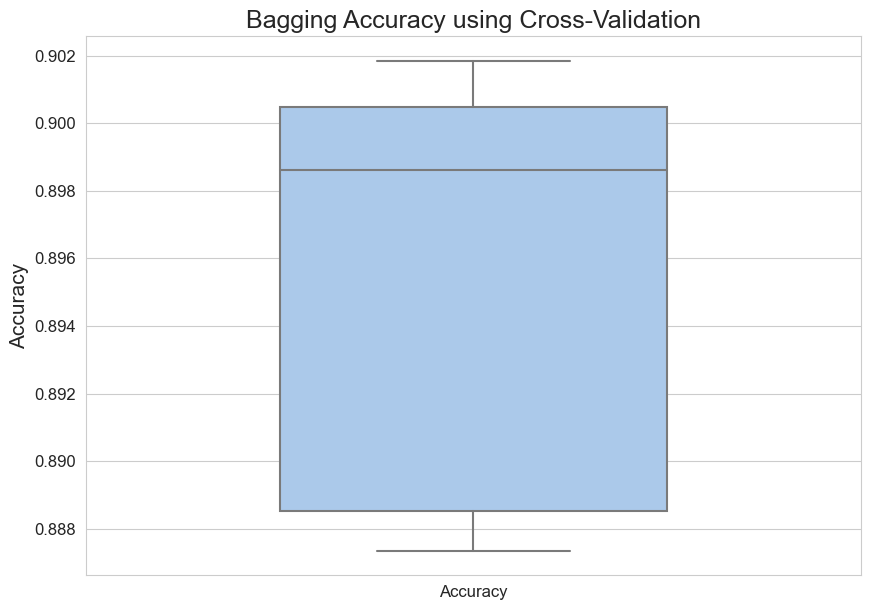

In [ ]:
if __name__ == '__main__':
    # the bagging Model
    rf_grid_search = GridSearchRoutine(X_train_selected, y_train, 'Bagging')
    rf_best_params, rf_best_scores, rf_cv_results = rf_grid_search.perform_grid_search()
    print("\nBagging Results:")
    print(f"Best Parameters: {rf_best_params['Bagging']}")
    print(f"Best Accuracy Score: {rf_best_scores['Bagging']}")
    rf_grid_search.visualize_scores()

#### GradientBoostingClassifier()


Gradient Boosting Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Accuracy Score: 0.9020030349013657


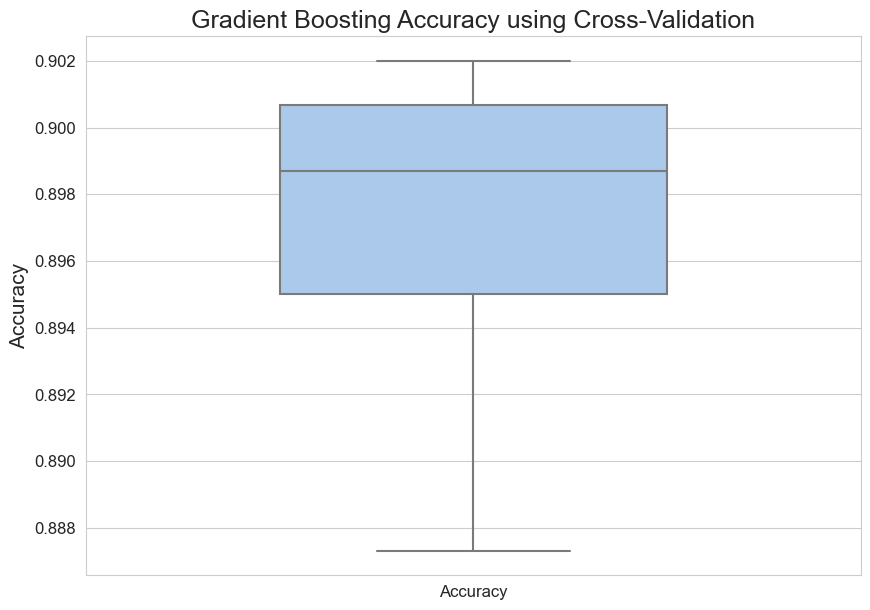

In [ ]:
if __name__ == '__main__':
    # the Gradient Boosting Model
    rf_grid_search = GridSearchRoutine(X_train_selected, y_train, 'Gradient Boosting')
    rf_best_params, rf_best_scores, rf_cv_results = rf_grid_search.perform_grid_search()
    print("\nGradient Boosting Results:")
    print(f"Best Parameters: {rf_best_params['Gradient Boosting']}")
    print(f"Best Accuracy Score: {rf_best_scores['Gradient Boosting']}")
    rf_grid_search.visualize_scores()

#### XGboostclassifier()


XGBoost Results:
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50}
Best Accuracy Score: 0.902670713201821


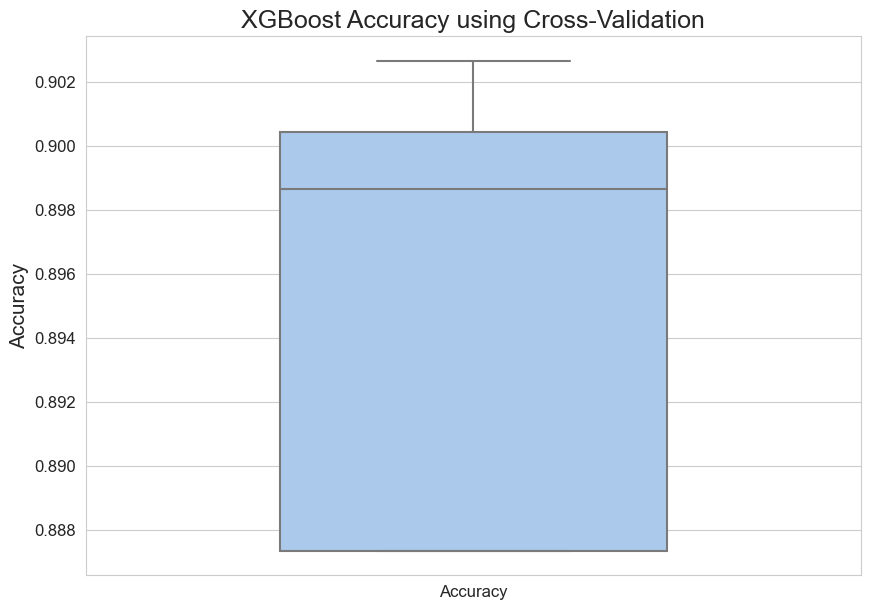

In [ ]:
if __name__ == '__main__':
    # the XGBoost Model
    rf_grid_search = GridSearchRoutine(X_train_selected, y_train, 'XGBoost')
    rf_best_params, rf_best_scores, rf_cv_results = rf_grid_search.perform_grid_search()
    print("\nXGBoost Results:")
    print(f"Best Parameters: {rf_best_params['XGBoost']}")
    print(f"Best Accuracy Score: {rf_best_scores['XGBoost']}")
    rf_grid_search.visualize_scores()

## Now perform the Random Search CV

In [ ]:
'''
The following class functions aim to evaluate the model with random search and hyperparameter tuning.
For the model, the functions will train the model and then return the corresponding accuracy and box plot for us to gain insights.
'''
class RandomSearchRoutine:
    # set the n_iter here in order to adjsut it, default will be 30
    def __init__(self, X_train, y_train, model_name, n_iter=30):
        self.X_train = X_train
        self.y_train = y_train
        self.model_name = model_name
        self.n_iter = n_iter

        self.models = {
            'RandomForest': RandomForestClassifier(random_state=1789),
            'Gradient Boosting': GradientBoostingClassifier(random_state=1789),
            'Bagging': BaggingClassifier(random_state=1789),
            'XGBoost': xgb.XGBClassifier(random_state=1789, eval_metric='logloss')
        }

        # for random serach, we will make the paramters grid be even larger so that we are able to
        # find most optimal combination (since it's not the exhaustive search live Grid serach CV)
        self.param_distributions = {
            'RandomForest': {
                'n_estimators': range(10, 250),
                'max_features': ['sqrt', 'log2', None],
                'class_weight': [None, 'balanced'],
                'max_depth': [None] + list(range(1, 20)),
                'min_samples_split': range(2, 11),
                'min_samples_leaf': range(1, 11),
                'criterion': ['gini', 'entropy']
            },
            'Gradient Boosting': {
                'n_estimators': range(10, 250),
                'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                'max_depth': range(1, 20),
                'min_samples_leaf': [1,2,3],
                'min_samples_split': [2,3,4]
            },
            'Bagging': {
                'n_estimators': range(10, 250),
                'max_samples': [0.1, 0.5, 0.9, 1.0],
                'max_features': [0.1, 0.5, 0.9, 1.0]
            },
            'XGBoost': {
                'n_estimators': range(10, 250),
                'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
                'max_depth': range(1, 20),
                'min_child_weight': range(1, 11),
                'subsample': [0.5, 0.75, 1.0],
                'colsample_bytree': [0.5, 0.75, 1.0]
            }
        }
    #remember the  result
        self.best_params = {}
        self.best_scores = {}
        self.cv_results = {}
    # do a random search
    def perform_random_search(self):
        model = self.models[self.model_name]
        rs = RandomizedSearchCV(model, self.param_distributions[self.model_name], n_iter=self.n_iter,
                                cv=5, scoring='accuracy', random_state=1789, return_train_score=True)
        rs.fit(self.X_train, self.y_train)
        self.best_params = rs.best_params_
        self.best_scores = rs.best_score_
        # stroage of the mean test scores for each hyperparameter combination
        self.cv_results = rs.cv_results_['mean_test_score']
        return self.best_params, self.best_scores, self.cv_results
    #display score
    def visualize_scores(self):
        plt.figure(figsize=(10, 6))
        sns.boxplot(y=self.cv_results)
        plt.title(
            f'{self.model_name} Accuracy using Random Search Cross-Validation')
        plt.ylabel('Accuracy')
        plt.show()
    #report the best result
    def report_best_params_and_score(self):
        print(f"Model: {self.model_name}")
        print(f"Best Parameters: {self.best_params}")
        print(f"Best Accuracy Score: {self.best_scores}\n")


#### RandomForestClassifier():

Model: RandomForest
Best Parameters: {'n_estimators': 92, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'class_weight': None}
Best Accuracy Score: 0.9020637329286798



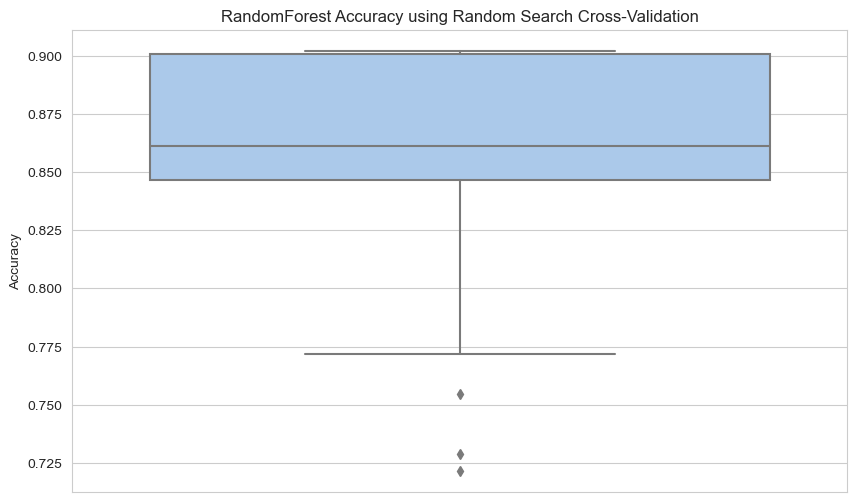

In [ ]:
if __name__ == '__main__':
    # the randomForest Model (Here we use n_iter of 50) ##
    rf_random_search = RandomSearchRoutine(
        X_train_selected, y_train, 'RandomForest', n_iter=50)
    rf_best_params, rf_best_scores, rf_cv_results = rf_random_search.perform_random_search()
    rf_random_search.report_best_params_and_score()
    rf_random_search.visualize_scores()

#### BaggingClassifier():

Model: Bagging
Best Parameters: {'n_estimators': 135, 'max_samples': 0.1, 'max_features': 1.0}
Best Accuracy Score: 0.9014567526555386



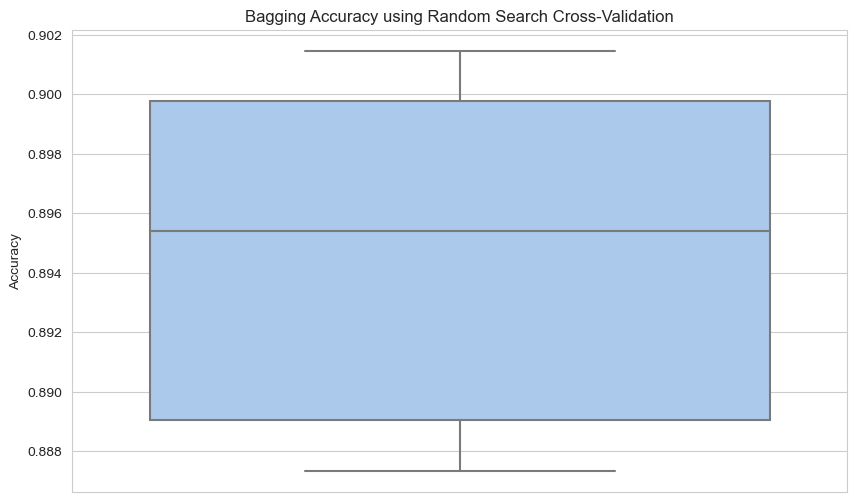

In [ ]:
if __name__ == '__main__':
    # the Bagging Model (Here we use n_iter of 50) ##
    rf_random_search = RandomSearchRoutine(
        X_train_selected, y_train, 'Bagging', n_iter=50)
    rf_best_params, rf_best_scores, rf_cv_results = rf_random_search.perform_random_search()
    rf_random_search.report_best_params_and_score()
    rf_random_search.visualize_scores()

#### GradientBoostingClassifier()

Model: Gradient Boosting
Best Parameters: {'n_estimators': 29, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1}
Best Accuracy Score: 0.9017602427921092



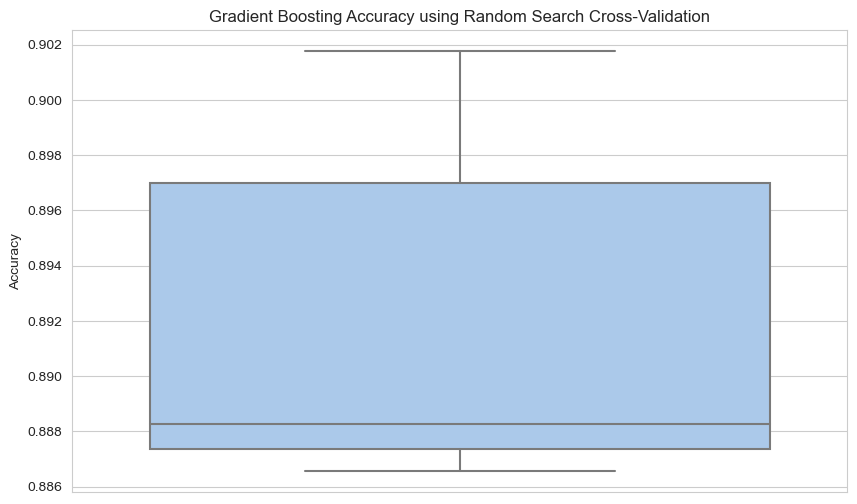

In [ ]:
if __name__ == '__main__':
    # the Gradient Boosting Model (Here we use n_iter of 50) ##
    rf_random_search = RandomSearchRoutine(
        X_train_selected, y_train, 'Gradient Boosting', n_iter=50)
    rf_best_params, rf_best_scores, rf_cv_results = rf_random_search.perform_random_search()
    rf_random_search.report_best_params_and_score()
    rf_random_search.visualize_scores()

#### XGboostclassifier()

Model: XGBoost
Best Parameters: {'subsample': 1.0, 'n_estimators': 240, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75}
Best Accuracy Score: 0.9018209408194234



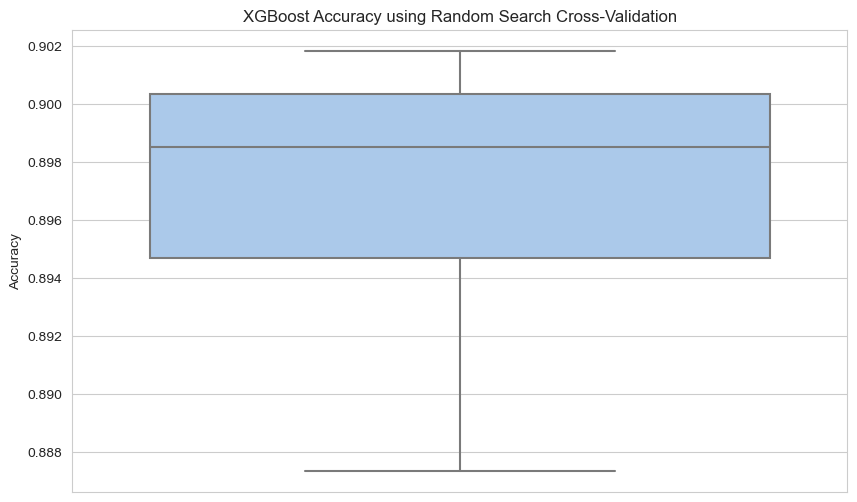

In [ ]:
if __name__ == '__main__':
    # the XGboost Model (Here we use n_iter of 50) ##
    rf_random_search = RandomSearchRoutine(
        X_train_selected, y_train, 'XGBoost', n_iter=50)
    rf_best_params, rf_best_scores, rf_cv_results = rf_random_search.perform_random_search()
    rf_random_search.report_best_params_and_score()
    rf_random_search.visualize_scores()

#### Random Forest

##### Default Settings
- **Accuracy**: 0.89041
- **Recall**: 0.317891
- **Precision**: 0.522396
- **Parameters**: Default settings with 100 trees, maximum features for splitting set to 'sqrt'.
- **Analysis**: The model provides a decent accuracy but has a low recall, indicating that it might be missing out on identifying a significant portion of the positive class.

##### Grid Search
- **Best Parameters**: 'class_weight': None, 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100
- **Best Accuracy Score**: 0.9025189681335355
- **Analysis**: The grid search has improved the accuracy compared to the default settings. The optimal max_depth found is 8, indicating that allowing the trees to grow deeper has benefited the model.

##### Random Search
- **Best Parameters**: 'n_estimators': 92, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'entropy', 'class_weight': None
- **Best Accuracy Score**: 0.9020637329286798
- **Analysis**: Random search has resulted in a similar accuracy to grid search but with a slightly more complex model (deeper trees). It also opted for the 'entropy' criterion instead of 'gini'.

#### Conclusion for Random Forest
- The grid search provided the best balance between accuracy and model complexity. The random search results in a more complex model without a significant gain in accuracy. Thus, I think grid serach still should be choosen in here.

---

#### Bagging

##### Default Settings
- **Accuracy**: 0.886677
- **Recall**: 0.307654
- **Precision**: 0.495552
- **Parameters**: Default settings with 10 trees.
- **Analysis**: The model shows lower performance metrics compared to Random Forest.

##### Grid Search
- **Best Parameters**: 'max_features': 0.5, 'max_samples': 0.1, 'n_estimators': 200
- **Best Accuracy Score**: 0.9018512898330805
- **Analysis**: The grid search has significantly improved the model’s accuracy. The optimal parameters suggest that using half of the features and 10% of the samples for each base estimator, along with a larger number of trees (200), is beneficial.

##### Random Search
- **Best Parameters**: 'n_estimators': 135, 'max_samples': 0.1, 'max_features': 1.0
- **Best Accuracy Score**: 0.901456752655538
- **Analysis**: Random search resulted in a performance boost, albeit slightly less pronounced than that achieved through grid search. The recommended configuration includes a moderately large ensemble size (135 trees) and a full utilization of features in each base estimator, highlighting a different pathway to achieving high model accuracy.

#### Conclusion for Bagging
- While the grid search model demonstrated slightly higher accuracy, the random search model achieved commendable performance with fewer estimators, showcasing a more efficient use of computational resources. This balance between accuracy and efficiency makes the random search model an attractive option, especially in scenarios where computational efficiency is paramount.

---

#### Gradient Boosting

##### Default Settings
- **Accuracy**: 0.901851
- **Recall**: 0.251897
- **Precision**: 0.671985
- **Parameters**: Default settings with 100 trees, max_depth of 3, and learning rate of 0.1.
- **Analysis**: The model has a high precision but lower recall, indicating that when it predicts the positive class, it is very likely to be correct, but it misses a lot of actual positive cases.

##### Grid Search
- **Best Parameters**: 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50
- **Best Accuracy Score**: 0.9020030349013657
- **Analysis**: The grid search results are very similar to the default settings, but with fewer trees (50 instead of 100). This indicates that the default settings were already quite good for this model.

##### Random Search
- **Best Parameters**: 'n_estimators': 29, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.1
- **Best Accuracy Score**: 0.9017602427921092
- **Analysis**: The random search has found a slightly better model with a higher learning rate and more trees than the default settings. This might indicate that the model benefits from a faster learning rate.

#### Conclusion for Gradient Boosting
- The grid search provided the best results, achieving the highest accuracy with a simpler model than the random search. The slight adjustment in the number of trees and the learning rate proved to be beneficial, making the grid search the preferred configuration for Gradient Boosting.

---

#### XGBoost

##### Default Settings
- **Accuracy**: 0.899181
- **Recall**: 0.282332
- **Precision**: 0.614323
- **Parameters**: Default settings.
- **Analysis**: The model provides a good balance between precision and recall, but there might be room for improvement.

##### Grid Search
- **Best Parameters**: 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50
- **Best Accuracy Score**: 0.902670713201821
- **Analysis**: The grid search has improved the accuracy, with a higher learning rate and fewer trees than the default settings. The optimal max_depth is found to be 4.

##### Random Search
- **Best Parameters**: 'subsample': 1.0, 'n_estimators': 240, 'min_child_weight': 4, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75
- **Best Accuracy Score**: 0.9018209408194234
- **Analysis**: The random search suggests a more complex model with more trees, deeper depth, and a slower learning rate. However, the improvement in accuracy is not as significant as with the grid search.

#### Conclusion for XGBoost
- The grid search provided the best results with a simpler model than the random search. The learning rate of 0.1 and max_depth of 4 seem to be beneficial for the XGBoost model.






### Therefore, we will use the Grid Search CV result for Random Forest, Gradient Boosting, and XGBoost, and the Random Search CV result for Bagging.

### Now put our best parameters for each base or meta model into the stacked classifier.

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

In [4]:
'''
The following function takes in the base and meta models. Then return the prediction value.
These functions aim to fit the model and train the model with cross validation.


'''
class StackedClassifier:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models  # It will be a list since we use multiple base models here
        self.meta_model = meta_model
        self.predictions = None  # Initialize as None; we'll set it in fit_with_cv
        self.accuracies = []  # Store accuracies

    # do  cross validation
    def fit_with_cv(self, X, y, cv_folds=5):
        n_samples, n_models = len(X), len(self.base_models)

        # start the  matrix to store predictions from each base model for each sample
        self.predictions = np.zeros((n_samples, n_models))

        kf = KFold(n_splits=cv_folds, shuffle=True, random_state=1789)
        y = y.to_numpy() if isinstance(y, pd.Series) else y

        for train_index, val_index in kf.split(X):
            fold_X_train, fold_X_val = X[train_index], X[val_index]
            fold_y_train, fold_y_val = y[train_index], y[val_index]

            fold_predictions = np.zeros((len(val_index), n_models))

            for idx, model in enumerate(self.base_models):
                # fit base model on the training portion of the fold
                model.fit(fold_X_train, fold_y_train)

                # predict using val set
                fold_y_pred = model.predict(fold_X_val)
                fold_predictions[:, idx] = fold_y_pred
                self.predictions[val_index, idx] = fold_y_pred

            # fit meta model on this fold's predictions and compute accuracy
            self.meta_model.fit(fold_predictions, fold_y_val)
            aggregated_predictions = self.meta_model.predict(fold_predictions)
            fold_accuracy = accuracy_score(fold_y_val, aggregated_predictions)
            self.accuracies.append(fold_accuracy)

        # fit our meta model based on all previous predictions
        self.meta_model.fit(self.predictions, y)


    #  prediction function
    def predict(self, X):
        meta_input = np.column_stack([
            model.predict(X) for model in self.base_models
        ])

        # now take the meta model and get the final predictions
        final_predictions = self.meta_model.predict(meta_input)

        return final_predictions

    def get_feature_importance(self, X):
        # double check if meta-model supports feature_importances_
        if not hasattr(self.meta_model, 'feature_importances_'):
            raise ValueError("Meta-model doesn't support feature_importances_ attribute.")

        # remember importance of each base model's predictions in meta-model
        meta_importances = self.meta_model.feature_importances_

        # re start  an array to store the cumulative feature importances
        cumulative_importances = np.zeros(X.shape[1])

        # compute each base model feature importance
        for idx, model in enumerate(self.base_models):
            if hasattr(model, 'feature_importances_'):
                # Weight the feature importance of this base model by its importance in the meta-model
                weighted_importance = model.feature_importances_ * meta_importances[idx]
                cumulative_importances += weighted_importance

        # normalization for the importances so they sum up to 1
        cumulative_importances = cumulative_importances / np.sum(cumulative_importances)

        return cumulative_importances



In [5]:
'''
This function does the similar process. It takes the base and meta model. Then returns confusion matrices and box plots
There are a few functions for different classifiers, stack classifiers, and plot the corresponding accuracies and confusion matrices

Here we utilize the random forest, bagging, gradient boosting as the base models, XGBoost as the meta model. The base models are selected based on the previous steps.
By using XGBoost, it can provide us with more effective comparsion and result.
'''
# run StackedClassifier and all other classifiers
class StackedClassifierRoutine:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models  # This should be a list of models
        self.meta_model = meta_model
        self.classifiers = self._initialize_classifiers()
        self.stacked_clf = self._create_stacked_classifier()
        self.scores = {"Accuracy": {}}
        self.confusion_matrices = {}
        self.cv_folds = 5

    def _initialize_classifiers(self):
        return {
            "Random Forest": RandomForestClassifier(random_state=1789),
            "Bagging": BaggingClassifier(random_state=1789),
            "Gradient Boosting": GradientBoostingClassifier(random_state=1789),
            "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=1789)
        }

    # interfer _create_stacked_classifier
    def _create_stacked_classifier(self):
        return StackedClassifier(self.base_models, self.meta_model)

    # train those base and meta models and the stacked classifier here
    def train(self, X_train, y_train):
        for name, model in self.classifiers.items():
            # make all the model predictions
            self.scores["Accuracy"][name] = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=self.cv_folds).tolist()

            # prepare the data for confusion matrix
            y_pred = cross_val_predict(model, X_train, y_train, cv=self.cv_folds)
            self.confusion_matrices[name] = confusion_matrix(y_train, y_pred)

        #  cross-validation
        self.stacked_clf.fit_with_cv(X_train, y_train, cv_folds=self.cv_folds)

        # member accuracies
        self.scores["Accuracy"]["Stacked Classifier"] = self.stacked_clf.accuracies

        y_pred_stacked = self.stacked_clf.predict(X_train)
        self.confusion_matrices["Stacked Classifier"] = confusion_matrix(y_train, y_pred_stacked)

    # plot all accuracies
    def plot_accuracies(self):
        df_scores = pd.DataFrame.from_dict(self.scores["Accuracy"], orient='index').T.melt(var_name='Model', value_name='Accuracy')

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=df_scores, x="Model", y="Accuracy",  palette="Set3", width=0.5, boxprops=dict(alpha=.3))
        plt.title("Model Accuracy Box Plot (across folds)")
        plt.xticks(rotation=45)
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    # plot all confusion matrices
    def plot_confusion_matrices(self):
        for name, matrix in self.confusion_matrices.items():
            plt.figure(figsize=(8, 6))
            sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix: {name}')
            plt.show()


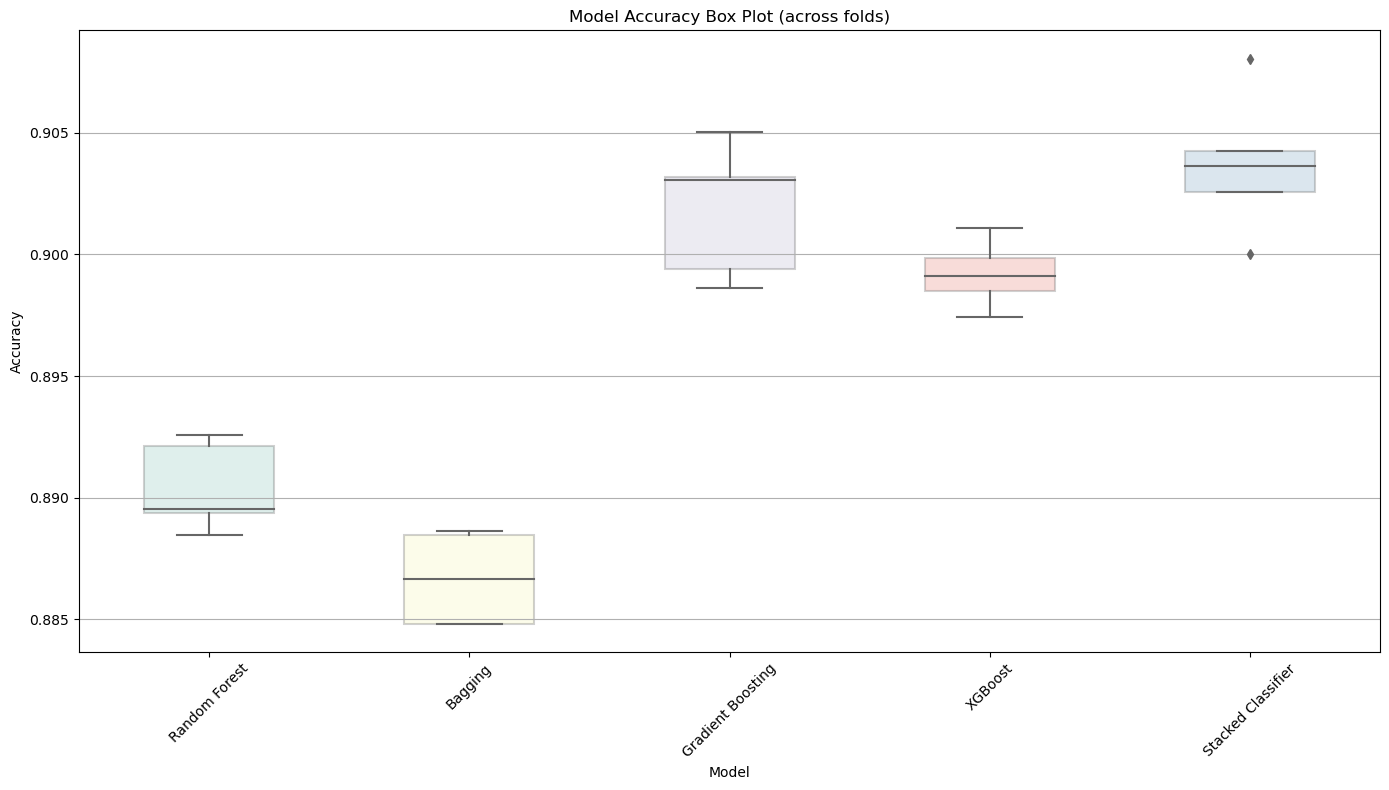

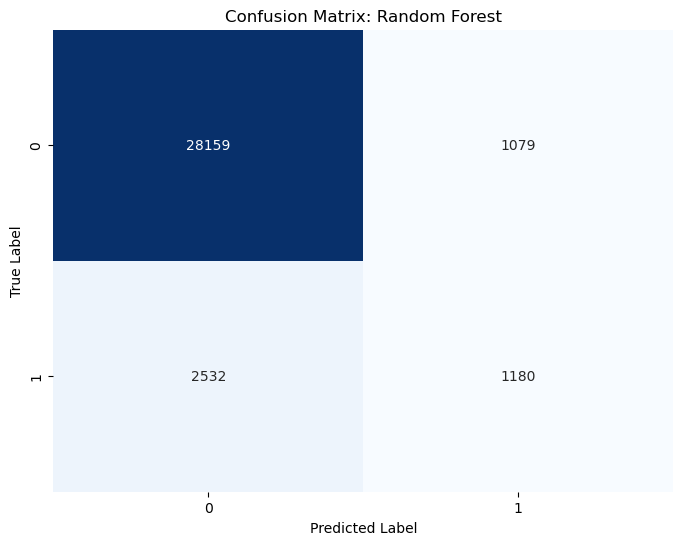

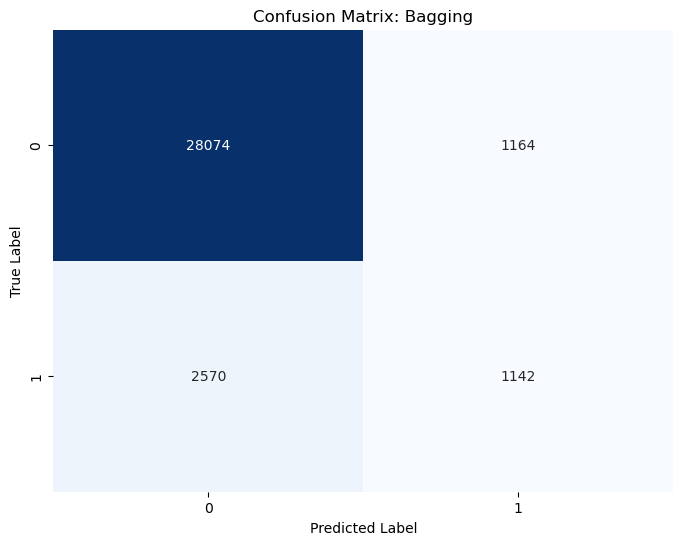

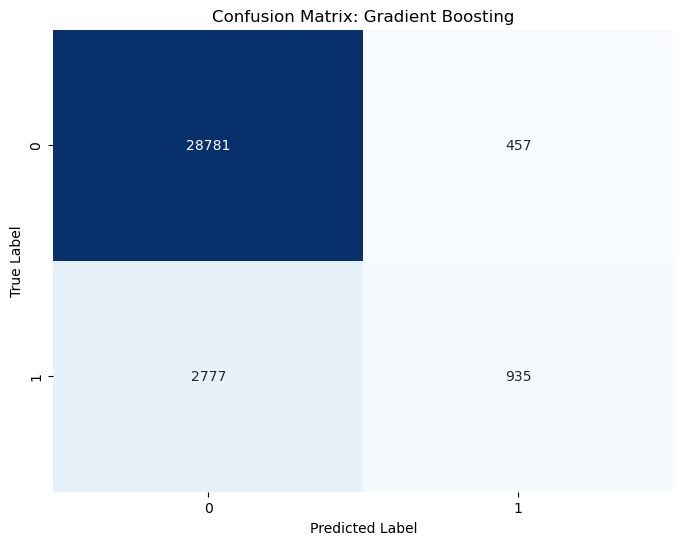

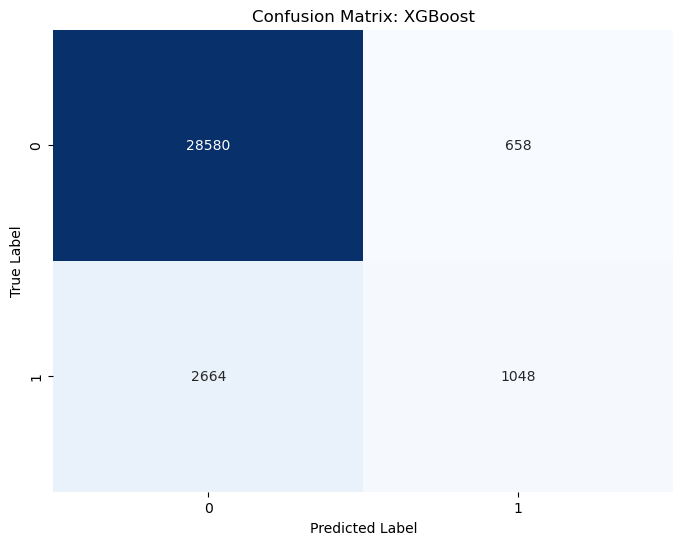

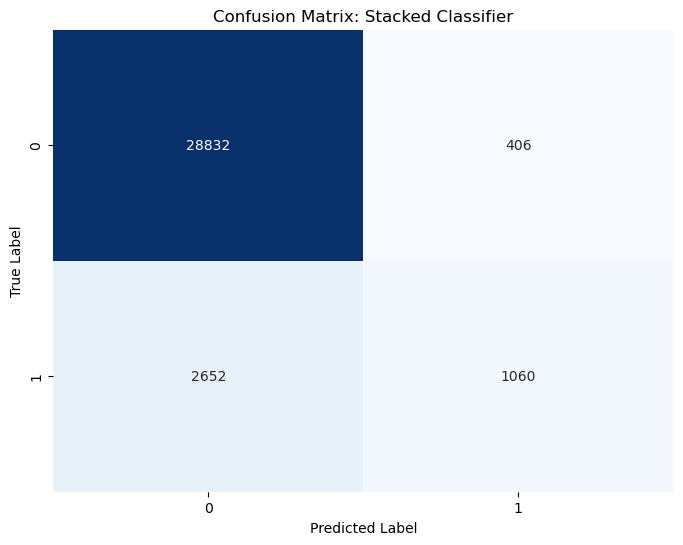

In [13]:
if __name__ == "__main__":
    # base and meta models for the stacked classifier
    base_models = [
        BaggingClassifier(max_features=1.0,max_samples=0.1,n_estimators=135,random_state=1789),
        GradientBoostingClassifier(learning_rate=0.1,max_depth=4,min_samples_split=2,min_samples_leaf=2,n_estimators=50,random_state=1789),
        RandomForestClassifier(class_weight=None, max_depth=8, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=1789)
    ]
    meta_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=2, n_estimators=50, eval_metric="logloss", random_state=1789)

    # run the StackedClassifierRoutine
    routine = StackedClassifierRoutine(base_models, meta_model)

    # train all the models including the stacked classifier
    routine.train(X_train_selected, y_train)

    # plot accuracies
    routine.plot_accuracies()

    # plot confusion matrices
    routine.plot_confusion_matrices()


### Stacked Model with hyperparameter tuning

In [14]:
import joblib
from sklearn.metrics import confusion_matrix

# export trained model to a Pickle file(which is the revised model)
model_filename = 'stacked_model_revised.pkl'
joblib.dump(routine.stacked_clf, model_filename)

# import trained model
loaded_model = joblib.load(model_filename)

# use imported model to predict y_test
y_pred_stacked = loaded_model.predict(X_test_selected)

# report confusion matrix
confusion = confusion_matrix(y_test, y_pred_stacked)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[7173  137]
 [ 696  232]]


Confusion Matrix:
[[7173  137]
 [ 696  232]]


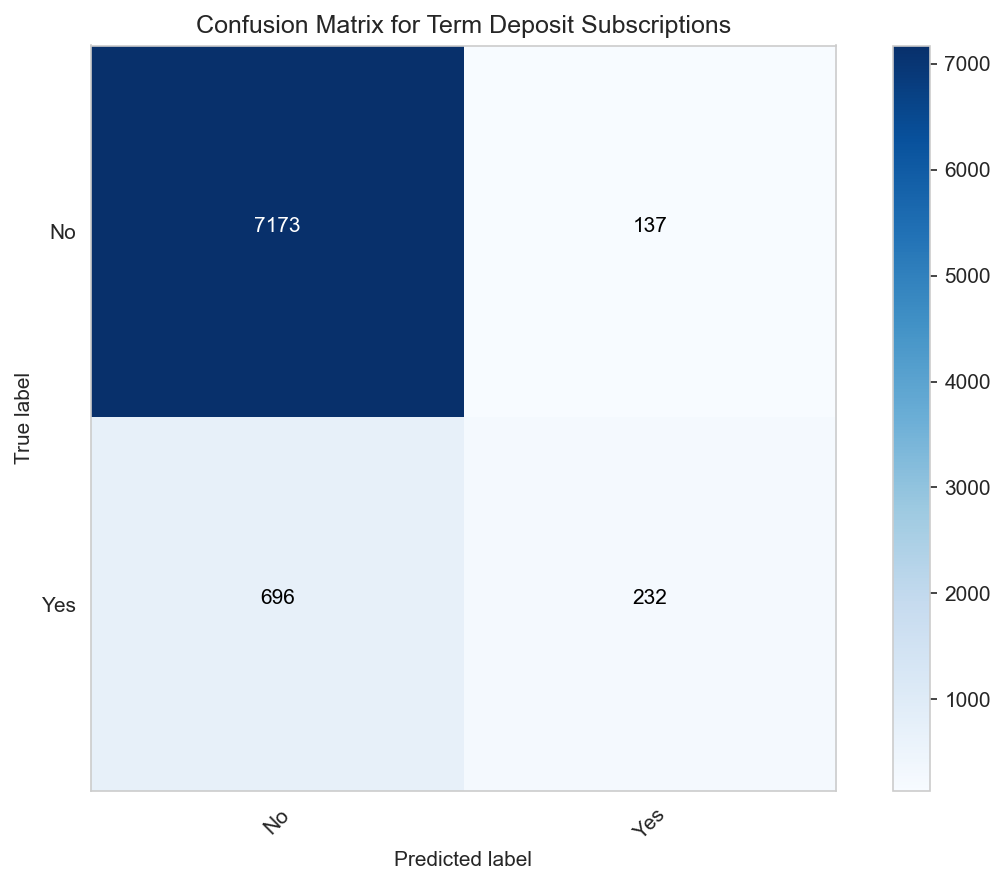

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

plt.rcParams['figure.dpi'] = 150

# compute confusion matrix using the loaded model to predict on the scaled test data
y_pred_stacked = loaded_model.predict(X_test_selected)
confusion = confusion_matrix(y_test, y_pred_stacked)

# show text confusion matrix
print("Confusion Matrix:")
print(confusion)

# show the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Term Deposit Subscriptions')  # Adjusted title
plt.colorbar()
classes = ['No', 'Yes']  # change class names
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# add in  the text values inside the matrix cells
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(confusion[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion[i, j] > confusion.max() / 2 else "black")


plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.grid(False)
# display the plot
plt.show()


## Summary

##### Compared with our previous model without tuning, the model actually get better prediction in true positives and true negatives, and our output stacked model size also decrease a lot thanks to the control in max depth and n_estimators.